In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from math import exp

%matplotlib inline

## FTSE

In [2]:
data = pd.read_csv('ftse100.csv', index_col=[0])

In [3]:
data.head()

,date,ftse100
1,1984-04-02,-0.011461
2,1984-04-03,0.000000
3,1984-04-04,0.006208
4,1984-04-05,-0.005353
5,1984-04-06,0.000365


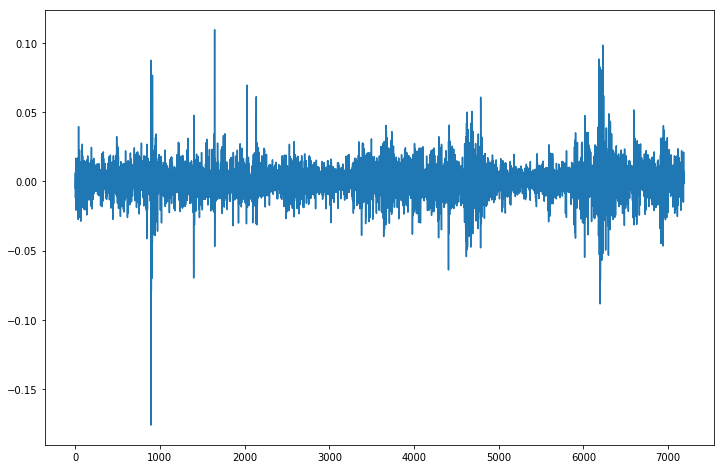

In [4]:
plt.figure(figsize=(12,8))

plt.plot(data.ftse100)

plt.show()

Возможные типы разладок:
* Увеличение/уменьшение среднего
* Увеличение/уменьшение дисперсии
  
Здесь хорошо наблюдается первый тип разладок.

Возьмем начальный отрезок длины 800.

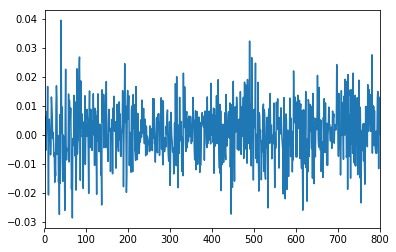

In [5]:
train = data.ftse100[:800]
train.plot()
plt.show()

Похоже, что это нормальное распределение. Оценим его параметры.

In [6]:
value = np.array(train)

a = np.mean(value)
sigma = np.mean(value ** 2) - (a ** 2)

In [7]:
print('%.5f' % a)

0.00092


Тогда логичным кажется считать разладкой увеличение/уменьшение среднего в 2 и более раз (под уменьшением понимается уход в отрицательные числа).

In [8]:
def cumsum(data, a, b, sigma):
    T = [0]
    n = len(data)
    for i in range(n):
        value = (b - a) * (data[i] - (b + a) / 2) / sigma
        T.append(max(0, T[-1] + value))
        
    return np.array(T)

In [9]:
def shr(data, a, b, sigma):
    T = [0]
    n = len(data)
    for i in range(n):
        value = (1 + T[-1]) * exp((b - a) * (data[i] - (b + a) / 2) / sigma)
        T.append(value)
        
    return np.array(T)

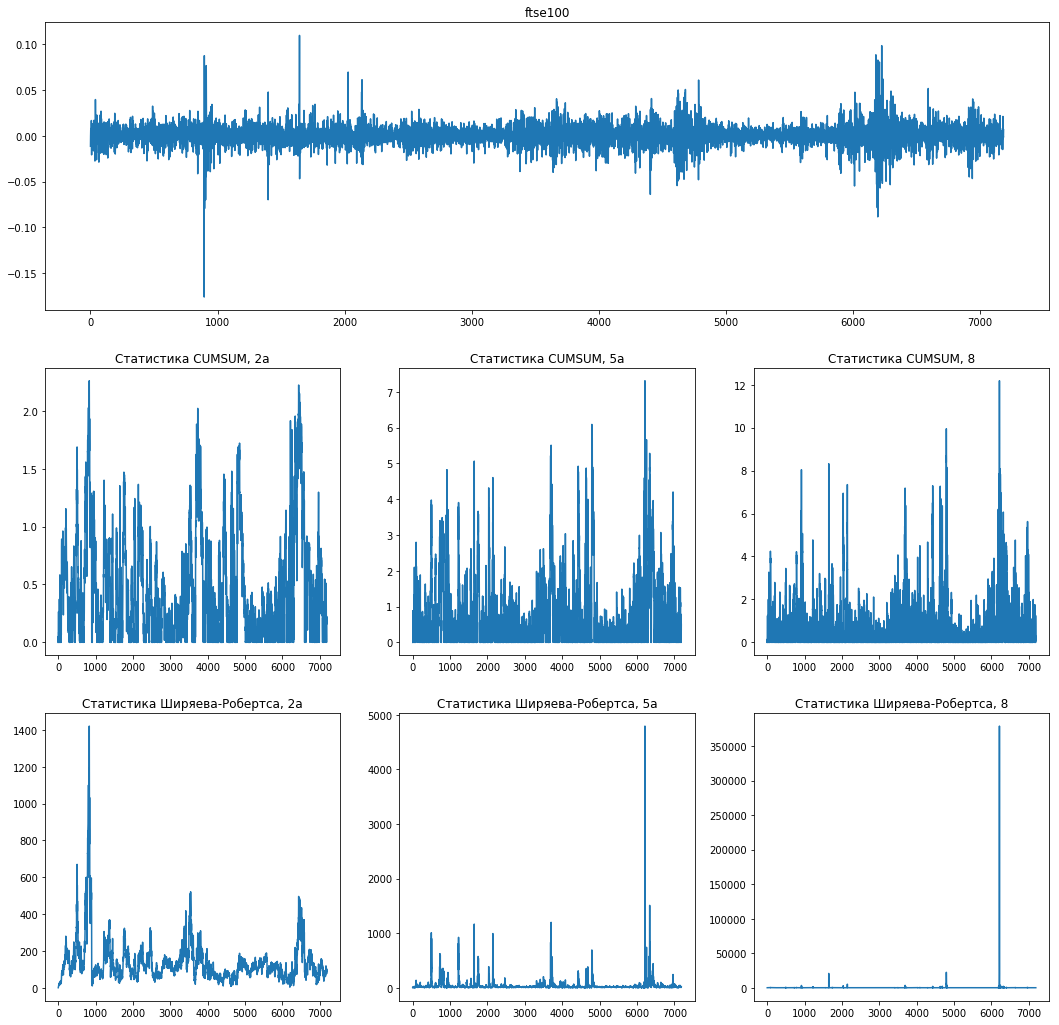

In [14]:
plt.figure(figsize=(18,18))

gs = gridspec.GridSpec(3, 3)

ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])
ax6 = plt.subplot(gs[2, 2])

ax0.plot(data.ftse100.tolist())
ax0.set_title('ftse100')

ax1.plot(cumsum(data.ftse100.tolist(), a, 2*a, sigma))
ax1.set_title('Статистика CUMSUM, 2a')

ax2.plot(cumsum(data.ftse100.tolist(), a, 5*a, sigma))
ax2.set_title('Статистика CUMSUM, 5a')

ax3.plot(cumsum(data.ftse100.tolist(), a, 8*a, sigma))
ax3.set_title('Статистика CUMSUM, 8')

ax4.plot(shr(data.ftse100.tolist(), a, 2*a, sigma))
ax4.set_title('Статистика Ширяева-Робертса, 2a')

ax5.plot(shr(data.ftse100.tolist(), a, 5*a, sigma))
ax5.set_title('Статистика Ширяева-Робертса, 5a')

ax6.plot(shr(data.ftse100.tolist(), a, 8*a, sigma))
ax6.set_title('Статистика Ширяева-Робертса, 8')

plt.show()

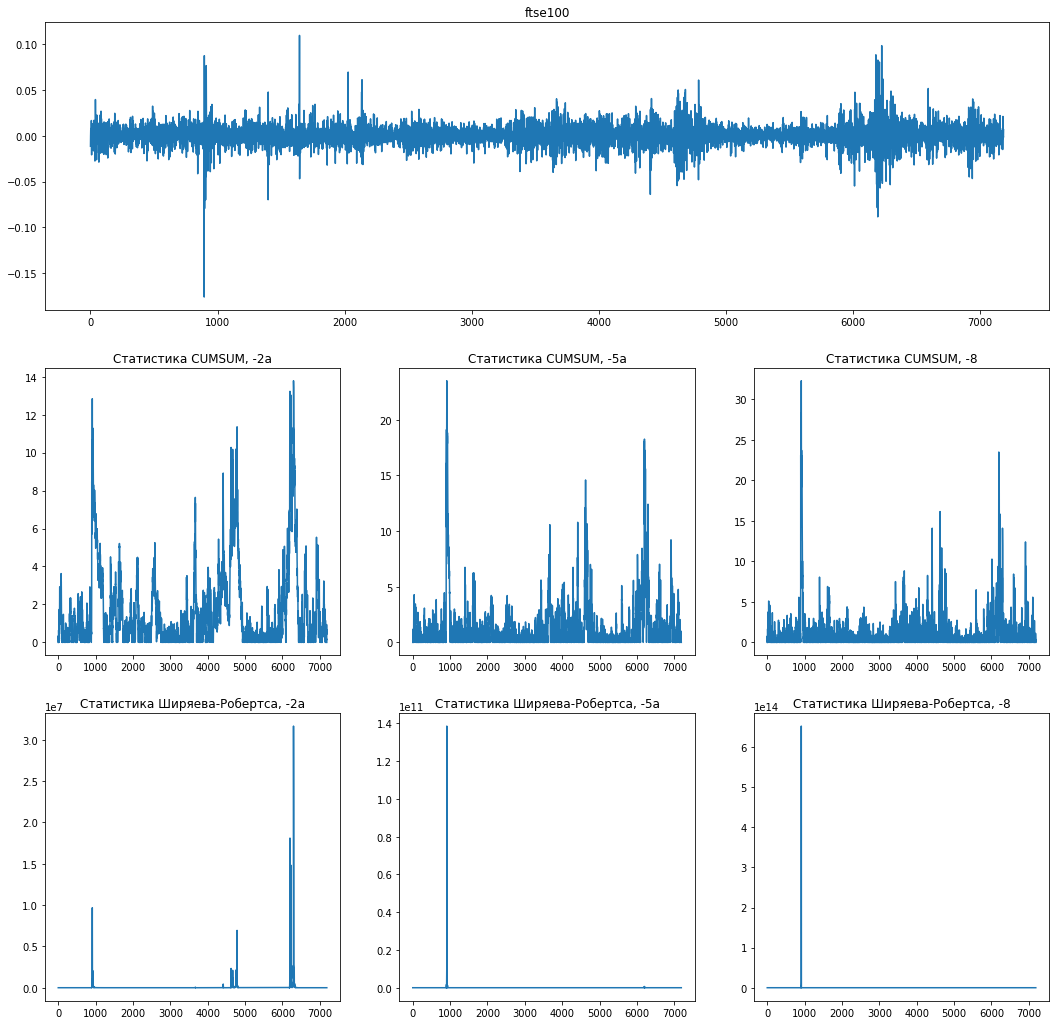

In [15]:
plt.figure(figsize=(18,18))

gs = gridspec.GridSpec(3, 3)

ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])
ax6 = plt.subplot(gs[2, 2])

ax0.plot(data.ftse100.tolist())
ax0.set_title('ftse100')

ax1.plot(cumsum(data.ftse100.tolist(), a, -2*a, sigma))
ax1.set_title('Статистика CUMSUM, -2a')

ax2.plot(cumsum(data.ftse100.tolist(), a, -5*a, sigma))
ax2.set_title('Статистика CUMSUM, -5a')

ax3.plot(cumsum(data.ftse100.tolist(), a, -8*a, sigma))
ax3.set_title('Статистика CUMSUM, -8')

ax4.plot(shr(data.ftse100.tolist(), a, -2*a, sigma))
ax4.set_title('Статистика Ширяева-Робертса, -2a')

ax5.plot(shr(data.ftse100.tolist(), a, -5*a, sigma))
ax5.set_title('Статистика Ширяева-Робертса, -5a')

ax6.plot(shr(data.ftse100.tolist(), a, -8*a, sigma))
ax6.set_title('Статистика Ширяева-Робертса, -8')

plt.show()

Из графиков получаем следующее:
* При поиске увеличения среднего стоит использовать $a_{0} = 5a$
* При поиске уменьшения среднего стоит использовать $a_{0} = -2a$

## Traffic

In [54]:
data = pd.read_csv('internet-traffic.csv', sep=';',
                   names=['time', 'traffic'], skiprows=[0])

In [55]:
data.head()

,time,traffic
0,2004-11-19 09:30:00,64554.479
1,2004-11-19 10:30:00,71138.749
2,2004-11-19 11:30:00,77253.266
3,2004-11-19 12:30:00,77340.780
4,2004-11-19 13:30:00,79860.759


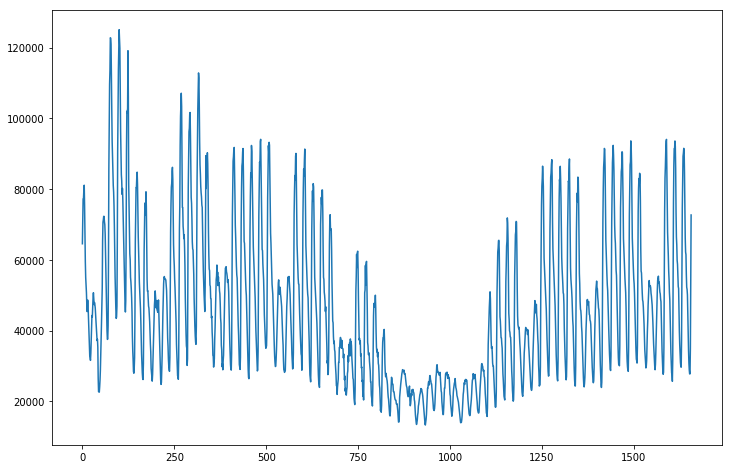

In [56]:
plt.figure(figsize=(12,8))

plt.plot(data.traffic)

plt.show()